Suppose there are 100 bank accounts for a group of companies for their 100 different business units. Now let's say from those accounts variable cash amounts (e.g., from stores to individual accounts) are deposited on daily basis (cash inflow) into a central account and certain amounts will be transferred from those accounts to other accounts like paying salary for the employees (cash outflow) or service charges, etc. Also, note that those 100 accounts might be within a single country or spread across countries. Let's say the central account will have all the liquid money in US Dollar.

How can we model this situation in the form of cash or liquidity forecasting problem such that  I can forecast how much liquid cash will still be there individual or central account so that the organization can take intelligent decision about investing the liquid money in profitable businesses. This is crucial because, otherwise those money will just be sitting idle.

Following code to generate synthetic data, by including factors such as different types of cash inflows and outflows, seasonality, trends, and perhaps external economic indicators to comply a real-world scenario.

In [1]:
!pip install -q pyspark darts mplcursors gradio==3.50

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.7/884.7 kB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 10.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 8.2 MB/s eta 0:00:00
     ━

#**Sample data generation**

In [79]:
import pandas as pd
import numpy as np

def generate_cash_in_outflow_data(start_date, end_date):
  # Set the random seed for reproducibility
  np.random.seed(0)

  # Generate month-end dates
  dates = pd.date_range(start=start_date, end=end_date, freq='M')

  # Number of accounts
  num_accounts = 1000

  # Create a MultiIndex with dates and account IDs
  multi_index = pd.MultiIndex.from_product([dates, range(num_accounts)], names=['date', 'account_id'])

  # Initialize an empty DataFrame with the MultiIndex
  df = pd.DataFrame(index=multi_index)

  # Define the number of periods (months)
  num_periods = len(dates)

  # Simulate seasonal patterns for cash inflows and outflows. Assuming a yearly seasonality with a sinusoidal pattern
  seasonality_inflows = np.sin(np.linspace(0, 2 * np.pi, num_periods))
  seasonality_outflows = np.sin(np.linspace(0, 2 * np.pi, num_periods))

  # Generate random cash inflows and outflows for each account on each date and add the seasonality effect
  df['cash_inflows'] = (np.random.normal(loc=100000, scale=20000, size=len(df)) + np.tile(seasonality_inflows, num_accounts))
  df['cash_outflows'] = (np.random.normal(loc=50000, scale=10000, size=len(df)) + np.tile(seasonality_outflows, num_accounts))

  # Simulate external economic factors (e.g., inflation rates). Let's assume we have inflation rates for 10 countries
  inflation_rates = [0.03, 0.025, 0.04, 0.02, 0.05, 0.03, 0.045, 0.025, 0.035, 0.03]  # Example rates
  df['inflation_factors'] = np.random.choice(inflation_rates, size=len(df))

  # Adjust cash flows based on inflation rates
  df['adjusted_cash_inflows'] = df['cash_inflows'] * (1 + df['inflation_factors'])

  # Calculate net cash flow
  df['net_cash_flow'] = df['adjusted_cash_inflows'] - df['cash_outflows']

  # Reset the index to turn the MultiIndex into columns
  df.reset_index(inplace=True)

  return df

In [80]:
# Define the date range
start_date = '2001-01-01'
end_date = '2024-03-31'

cash_flow_df = generate_cash_in_outflow_data(start_date, end_date)

# **EDA**

In [82]:
cash_flow_df_sampled = cash_flow_df.sample(frac=0.01)
cash_flow_df_sampled.head(100)

,date,account_id,cash_inflows,cash_outflows,inflation_factors,adjusted_cash_inflows,net_cash_flow
268137,2023-05-31,137,129896.584196,37108.842585,0.040,135092.447563,97983.604978
174878,2015-07-31,878,103612.933088,62592.819957,0.030,106721.321080,44128.501123
272604,2023-09-30,604,126872.809462,53354.700505,0.025,130044.629699,76689.929194
89047,2008-06-30,47,87412.873874,37045.515699,0.020,89161.131351,52115.615652
112151,2010-05-31,151,110953.097341,34570.903881,0.030,114281.690261,79710.786380
...,...,...,...,...,...,...,...
12178,2002-01-31,178,112328.476817,64284.665632,0.045,117383.258274,53098.592642
246253,2021-07-31,253,74453.308188,63359.224034,0.035,77059.173975,13699.949940
46534,2004-11-30,534,121831.514115,38313.471758,0.020,124268.144398,85954.672639
143713,2012-12-31,713,73802.431716,54187.723716,0.035,76385.516826,22197.793110


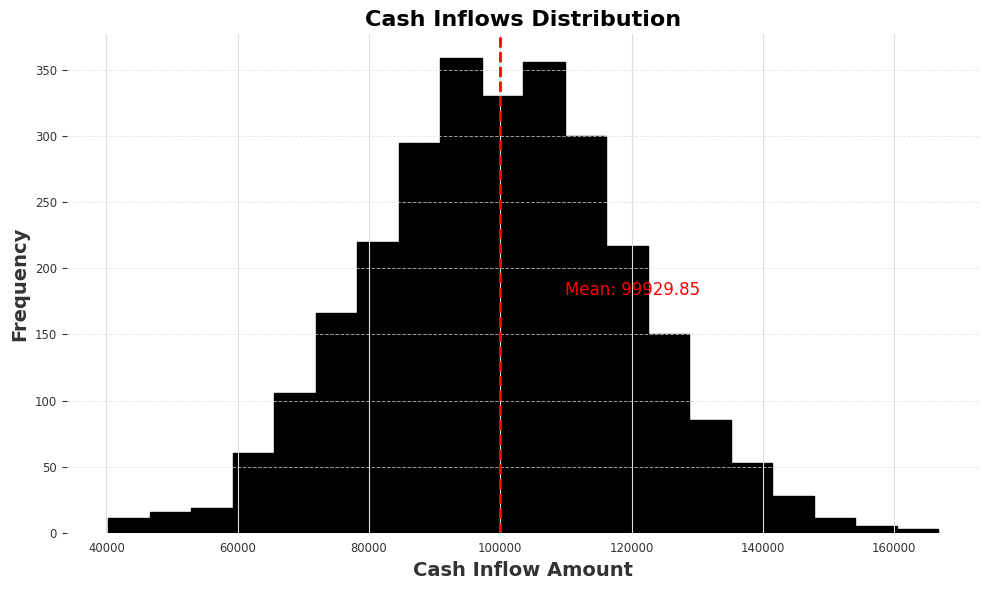

In [87]:
from matplotlib import pyplot as plt

# Create the histogram plot
plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(cash_flow_df_sampled['cash_inflows'], bins=20, color='skyblue', edgecolor='black')

# Add a title and labels
plt.title('Cash Inflows Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Cash Inflow Amount', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Remove the top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Annotate the mean value on the plot
mean_value = sum(cash_flow_df_sampled['cash_inflows']) / len(cash_flow_df_sampled['cash_inflows'])
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2)
plt.text(mean_value*1.1, max(plt.hist(cash_flow_df_sampled['cash_inflows'], bins=20)[0])/2, f'Mean: {mean_value:.2f}', color='red', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

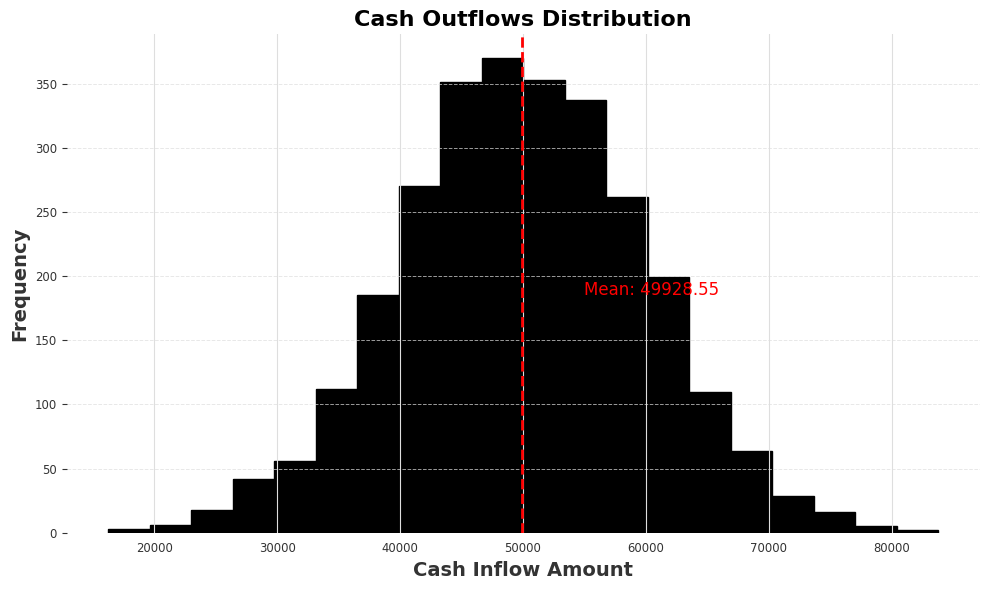

In [88]:
from matplotlib import pyplot as plt

# Create the histogram plot
plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(cash_flow_df_sampled['cash_outflows'], bins=20, color='skyblue', edgecolor='black')

# Add a title and labels
plt.title('Cash Outflows Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Cash Inflow Amount', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Remove the top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Annotate the mean value on the plot
mean_value = sum(cash_flow_df_sampled['cash_outflows']) / len(cash_flow_df_sampled['cash_outflows'])
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2)
plt.text(mean_value*1.1, max(plt.hist(cash_flow_df_sampled['cash_outflows'], bins=20)[0])/2, f'Mean: {mean_value:.2f}', color='red', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

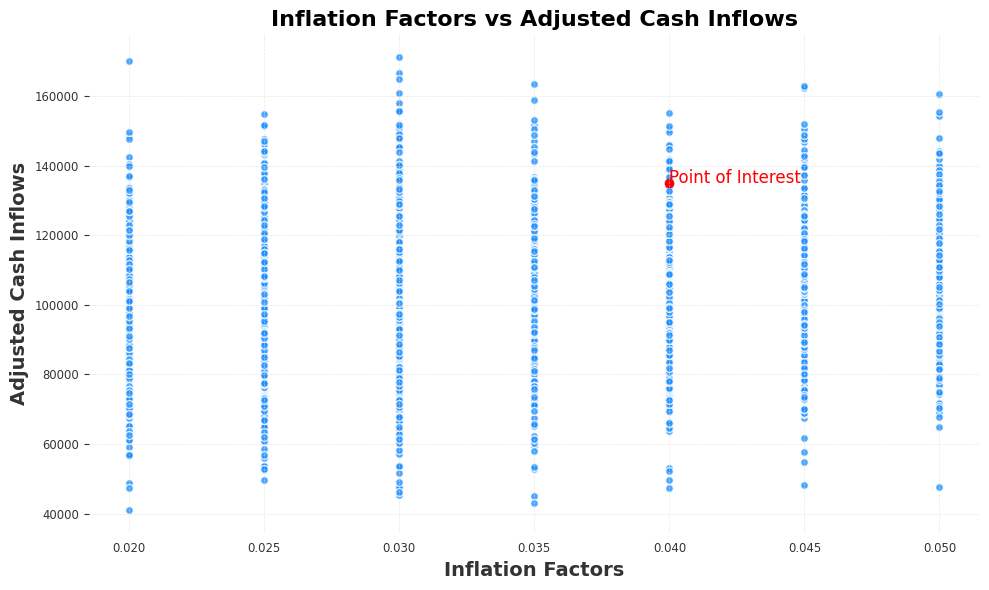

In [91]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 6))  # Set the figure size
plt.scatter(cash_flow_df_sampled['inflation_factors'], cash_flow_df_sampled['adjusted_cash_inflows'],
s=32, alpha=0.8, color='dodgerblue', edgecolors='w')  # Set color and edgecolor

# Add a title and labels
plt.title('Inflation Factors vs Adjusted Cash Inflows', fontsize=16, fontweight='bold')
plt.xlabel('Inflation Factors', fontsize=14)
plt.ylabel('Adjusted Cash Inflows', fontsize=14)

# Remove the top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add gridlines for better readability
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Annotate a point of interest (example coordinates)
point_of_interest = (cash_flow_df_sampled['inflation_factors'].iloc[0], cash_flow_df_sampled['adjusted_cash_inflows'].iloc[0])
plt.scatter(*point_of_interest, color='red')  # Highlight the point
plt.text(point_of_interest[0], point_of_interest[1], 'Point of Interest', color='red', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

•  **Positive Correlation**: If the scatter plot shows an upward trend, where higher inflation factors correspond to higher cash inflows, this suggests a positive correlation. It could mean that as inflation increases, the cash inflows also increase, possibly due to adjustments in pricing, revenue growth, or other factors that scale with inflation.

•  **Negative Correlation**: Conversely, a downward trend would suggest a negative correlation. This would indicate that higher inflation factors are associated with lower cash inflows, which could be due to a variety of economic pressures that reduce revenue or cash intake as inflation rises.

•  **No Correlation**: If the points are scattered without any discernible pattern, it might indicate that there is no significant relationship between inflation factors and cash inflows for the sampled data.

•  **Outliers**: Points that stand out from the general pattern could indicate exceptional cases or outliers that may warrant further investigation.

•  **Clusters**: Groupings of points could suggest that there are specific ranges of inflation factors where cash inflows tend to be similar, which might reveal different behaviors or regimes in the data.

# **Standalone cash liquidity forecasting**

In [92]:
# Aggregate the net cash flow for each date to get the total liquidity
total_liquidity = cash_flow_df.groupby('date')['net_cash_flow'].sum().reset_index()
total_liquidity.head()

,date,net_cash_flow
0,2001-01-31,5.229386e+07
1,2001-02-28,5.322458e+07
2,2001-03-31,5.208825e+07
3,2001-04-30,5.302716e+07
4,2001-05-31,5.401558e+07


In [93]:
%%time
from darts import TimeSeries
from darts.models import Prophet
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import Prophet
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mplcursors
import pandas as pd
from darts import TimeSeries
from darts.models import Prophet

def standalone_model_training_for_liquidity_forecasting(df):
  # Aggregate the net cash flow for each date to get the total liquidity
  total_liquidity = df.groupby('date')['net_cash_flow'].sum().reset_index()

  # Convert the aggregated data into a Darts TimeSeries object
  train_series = TimeSeries.from_dataframe(total_liquidity, time_col='date', value_cols='net_cash_flow', fill_missing_dates=True, freq='M')

  # Create and fit the Prophet model
  model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=4)
  model.fit(train_series)

  return model, train_series

def standalone_liquidity_forecasting(model, forecast_horizon):
  # Forecast the future liquidity for the next 'n' periods
  forecast = model.predict(n=forecast_horizon, num_samples=1000)

  # Extract the quantiles to get the confidence intervals
  lower_quantile = forecast.quantile_timeseries(0.05)
  upper_quantile = forecast.quantile_timeseries(0.95)

  return forecast, lower_quantile, upper_quantile

CPU times: user 63 µs, sys: 0 ns, total: 63 µs
Wall time: 68.7 µs


In [94]:
def plot_liquidity_forecast(series, forecast, lower_quantile, upper_quantile):
  # Plot the forecast alongside the actual data
  plt.figure(figsize=(13, 6))
  ax = plt.gca()  # Get the current Axes instance

  # Plot actual and forecast series
  actual_plot, = ax.plot(series.time_index, series.values(), label='Actual', color='black')
  forecast_plot, = ax.plot(forecast.time_index, forecast.values(), label='Forecast', color='blue')
  lower_quantile_plot, = ax.plot(lower_quantile.time_index, lower_quantile.values(), label='5th percentile', color='green')
  upper_quantile_plot, = ax.plot(upper_quantile.time_index, upper_quantile.values(), label='95th percentile', color='red')

  # Add vertical dashed lines for important dates
  campaign_start = pd.Timestamp('2022-01-01')
  campaign_end = pd.Timestamp('2022-06-01')
  product_launch = pd.Timestamp('2023-06-01')
  plt.axvline(x=campaign_start, color='red', linestyle='--', linewidth=1, label='Campaign Start')
  plt.axvline(x=campaign_end, color='red', linestyle='--', linewidth=1, label='Campaign End')
  plt.axvline(x=product_launch, color='green', linestyle='--', linewidth=1, label='Product Launch')

  # Annotate with arrows
  plt.annotate('Horizon', xy=(forecast.time_index[-1], forecast.values()[-1]),
  xytext=(forecast.time_index[-30], forecast.values()[-1] + 50000),
  arrowprops=dict(facecolor='orange', shrink=0.05), fontsize=9)
  plt.annotate('Period Focus', xy=(campaign_start, ax.get_ylim()[0]),
  xytext=(campaign_start, ax.get_ylim()[1] - 50000),  # Move the text up by using the upper y-limit
  arrowprops=dict(facecolor='purple', shrink=0.05), fontsize=9)
  plt.annotate('Cut-off', xy=(campaign_end, ax.get_ylim()[0]),
  xytext=(campaign_end, ax.get_ylim()[0] + 50000),
  arrowprops=dict(facecolor='brown', shrink=0.05), fontsize=9)

  # Set title, labels, and legend
  plt.title('Liquidity Forecast with Confidence Intervals')
  plt.xlabel('Date')
  plt.ylabel('Net Cash Flow')
  plt.legend(ncol=len(ax.lines), loc='upper center', bbox_to_anchor=(0.5, -0.1))

  # Improve date formatting on the x-axis
  ax.xaxis.set_major_locator(mdates.YearLocator())
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
  ax.xaxis.set_minor_locator(mdates.AutoDateLocator())
  ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

  # Rotate date labels for better readability
  plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
  plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)

  # Show gridlines
  plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)

  # Use mplcursors to add interactive hover tooltips
  cursor = mplcursors.cursor(hover=True)
  cursor.connect("add", lambda sel: sel.annotation.set_text(
  'Date: {}\nNet Cash Flow: ${:.2f}'.format(pd.to_datetime(sel.target[0]).strftime('%Y-%m-%d'), sel.target[1])))

  # Show the plot
  plt.tight_layout()
  plt.show()

In [95]:
model, train_series = standalone_model_training_for_liquidity_forecasting(cash_flow_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6x00opz0/_tq9udul.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6x00opz0/dl2d1xtl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63157', 'data', 'file=/tmp/tmp6x00opz0/_tq9udul.json', 'init=/tmp/tmp6x00opz0/dl2d1xtl.json', 'output', 'file=/tmp/tmp6x00opz0/prophet_model7tvaioyr/prophet_model-20240428204456.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:44:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:44:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [103]:
forecast_horizon = 30
forecast, lower_quantile, upper_quantile = standalone_liquidity_forecasting(model, forecast_horizon)

# Sum all net_cash_flow columns for each date
forecast_pdf = forecast.pd_dataframe()

In [104]:
forecast_pdf['forecasted_net_cash_flow'] = forecast_pdf.filter(regex='^net_cash_flow_s').mean(axis=1)

forecast_pdf['date'] = forecast_pdf.index
forecast_pdf = forecast_pdf.reset_index(drop=True)
forecast_pdf = forecast_pdf[['date', 'forecasted_net_cash_flow']]

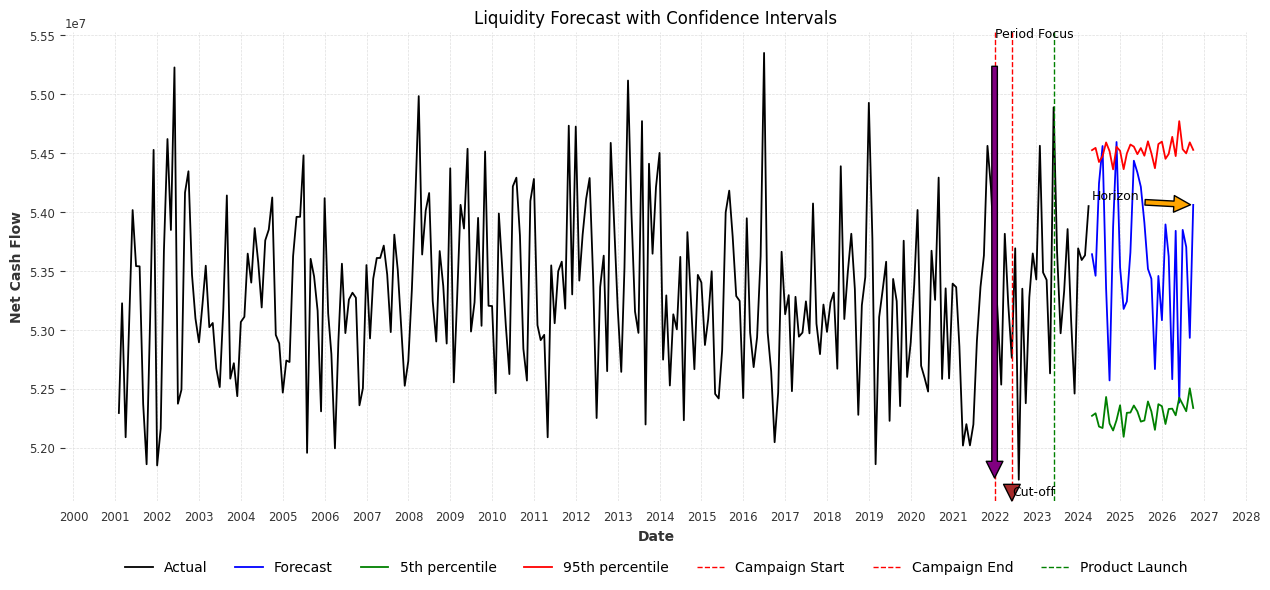

In [105]:
plot_liquidity_forecast(train_series, forecast, lower_quantile, upper_quantile)

•  Cut-off: This is a point in time at which the data is divided into two parts: the historical data used for training the model, and the future period for which predictions are made. The cut-off date is crucial because it determines the dataset that will be used to train the forecasting model.

•  Period Focus: As previously mentioned, this refers to the granularity of the forecast, such as hourly, daily, or monthly forecasts. It's about choosing the right time interval that aligns with the specific needs of the forecast.

In [106]:
forecast_pdf.head()

,date,forecasted_net_cash_flow
0,2024-04-30,5.337346e+07
1,2024-05-31,5.342146e+07
2,2024-06-30,5.331638e+07
3,2024-07-31,5.331161e+07
4,2024-08-31,5.350555e+07


## **Conformal prediciton interval for better uncertanity quantification**

To introduce conformal prediction into your time series forecasting following steps are needed:

1. **Spliting data into a training- and a calibration set**: The calibration set is used to determine the conformity scores which are essential for conformal prediction.

2. **Model training**: train the model on the train set by taking into consideration factors like seasonality if needed.

3. **Generating predictions on calibration set and calculating the conformity scores**: The conformity score can be calculated w.r.t absolute error between the predicted and actual values.

4. **Setting a significance level**: Set confidence level, e.g., 0.05 for 95% confidence and use the conformity scores to determine the prediction intervals for new data points.

5. **Predict future data points:** predict future data points for a required forecast horizon using the trained model and calculate the upper and lower bounds of the prediction intervals based on the conformity scores and the significance level.

In [80]:
# # Assuming 'df' is your DataFrame and it has been preprocessed accordingly

# # Split the data into training and calibration sets
# train_df = df[df['date'] <= 'cutoff_date']  # replace 'cutoff_date' with the actual date
# calibration_df = df[df['date'] > 'cutoff_date']

# # Your existing training function
# model, train_series = standalone_model_training_for_liquidity_forecasting(train_df)

# # Generate predictions on the calibration set
# calibration_series = TimeSeries.from_dataframe(calibration_df, 'date', 'net_cash_flow')
# calibration_forecast = model.predict(calibration_series)

# # Calculate conformity scores (absolute errors) on the calibration set
# conformity_scores = abs(calibration_series.values() - calibration_forecast.values())

# # Determine the prediction intervals
# alpha = 0.05  # for a 95% confidence interval
# quantile = 1 - alpha
# upper_bound = np.quantile(conformity_scores, quantile)
# lower_bound = -upper_bound  # assuming symmetry for simplicity

# # Now,following bounds can be added to get the prediction intervals, while predicting for future data points
# forecast, _, _ = standalone_liquidity_forecasting(model)
# forecast_upper = forecast.values() + upper_bound
# forecast_lower = forecast.values() + lower_bound

# **Distributed cash liquidity forecasting with PySpark**

> Add blockquote



### **Using Pandas UDFs vs. Python UDFs**
Together with Apache Spark and Apache Arrow, Pandas User Defined Functions (UDFs) use the Pandas library for data manipulation in order to allow writing more performant UDFs as compared to Python UDFs. More advantegiously, they also bring the power of the Pandas library and allow its capabilities to be used in PySpark code.

In [81]:
# from pyspark.sql import SparkSession
# from pyspark.sql.functions import pandas_udf, PandasUDFType
# from pyspark.sql.types import *
# from pyspark.sql.functions import pandas_udf
# from pyspark.sql.types import StructType, StructField, TimestampType, IntegerType, DoubleType

# # Initialize Spark session
# spark = SparkSession.builder.appName('average_example').getOrCreate()

# # Define the schema for the output DataFrame
# schema = StructType([
# StructField('average_net_cash_flow', DoubleType(), True)
# ])

# # Define the pandas_udf function
# @pandas_udf(schema, PandasUDFType.GROUPED_MAP)
# def calculate_average(df):
#   average_value = df['net_cash_flow'].mean()

#   return pd.DataFrame({'average_net_cash_flow': [average_value]})

# total_liquidity = df.groupby('date')['net_cash_flow'].sum().reset_index()
# sdf = spark.createDataFrame(total_liquidity)

# # Apply the pandas_udf function to the DataFrame
# average_df = sdf.groupby('date').apply(calculate_average)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/group_ops.py:104: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [108]:
%%time
from pyspark.sql import SparkSession
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import *
from pyspark.sql.functions import pandas_udf
from pyspark.sql.types import StructType, StructField, TimestampType, IntegerType, DoubleType

import pandas as pd
from darts import TimeSeries
from darts.models import Prophet

# Initialize a Spark session
spark = SparkSession.builder.appName("LiquidityForecasting").getOrCreate()

schema = StructType([
StructField('date', TimestampType(), True),
StructField('forecast_net_cash_flow', DoubleType(), True)
])

# Define the pandas_udf function
@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def forecast_timeseries(df):
  # Convert the data into a Darts TimeSeries object
  train_series = TimeSeries.from_dataframe(df, time_col='date', value_cols='net_cash_flow', fill_missing_dates=True, freq='M')

  # Create and fit the Prophet model
  model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=4)
  model.fit(train_series)

  # Forecast the future liquidity
  forecast_horizon = 30  # Adjust the forecast horizon as needed
  forecast = model.predict(n=forecast_horizon)

  # Prepare the forecast DataFrame to match the specified schema
  forecast_df = forecast.pd_dataframe()
  forecast_df.reset_index(inplace=True)
  forecast_df.columns = ['date', 'forecast_net_cash_flow']
  #forecast_df['total_mean_forecasted_net_cash_flow'] = forecast_df.filter(regex='^total_mean_forecasted_net_cash_flow_s').mean(axis=1)

  # Return the forecast as a Pandas DataFrame
  return forecast_df

# Assuming 'sdf' is a Spark DataFrame with 'date' and 'net_cash_flow' columns. Apply the pandas_udf function to the DataFrame
total_liquidity = cash_flow_df.groupby('date')['net_cash_flow'].sum().reset_index()
sdf = spark.createDataFrame(total_liquidity)
forecast_sdf = sdf.groupby().apply(forecast_timeseries)

CPU times: user 34.7 ms, sys: 3.01 ms, total: 37.7 ms
Wall time: 112 ms


/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/group_ops.py:104: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


CPU times: user 2.58 s, sys: 664 ms, total: 3.25 s
Wall time: 3.32 s

In [109]:
forecast_sdf.show()

+-------------------+----------------------+
|               date|forecast_net_cash_flow|
+-------------------+----------------------+
|2024-04-30 00:00:00|   5.337360813521646E7|
|2024-05-31 00:00:00|   5.345180789159445E7|
|2024-06-30 00:00:00|   5.336524027605915E7|
|2024-07-31 00:00:00|   5.333658465074554E7|
|2024-08-31 00:00:00|   5.347870139648577E7|
|2024-09-30 00:00:00|   5.334843956221805E7|
|2024-10-31 00:00:00|   5.324980584623329E7|
|2024-11-30 00:00:00|  5.3452024265207864E7|
|2024-12-31 00:00:00|   5.341091760780195E7|
|2025-01-31 00:00:00|  5.3249331578550085E7|
|2025-02-28 00:00:00|  5.3351927004439056E7|
|2025-03-31 00:00:00|  5.3419905829047084E7|
|2025-04-30 00:00:00|  5.3415831061436765E7|
|2025-05-31 00:00:00|  5.3494428286103755E7|
|2025-06-30 00:00:00|   5.340911415656186E7|
|2025-07-31 00:00:00|   5.337828448342218E7|
|2025-08-31 00:00:00|   5.352114260675385E7|
|2025-09-30 00:00:00|    5.33930540644775E7|
|2025-10-31 00:00:00|  5.3291511146206714E7|
|2025-11-3

In [111]:
forecast_pdf.head(12)

,date,forecasted_net_cash_flow
0,2024-04-30,5.337346e+07
1,2024-05-31,5.342146e+07
2,2024-06-30,5.331638e+07
3,2024-07-31,5.331161e+07
4,2024-08-31,5.350555e+07
5,2024-09-30,5.336735e+07
6,2024-10-31,5.326157e+07
7,2024-11-30,5.341517e+07
8,2024-12-31,5.340416e+07
9,2025-01-31,5.321930e+07
